In [5]:
from utils import balance_sample, univariate_classifier, bad_participant, correct_name_markers

import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as pgo
import plotly.offline as pyo
import plotly.io as pio
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected = True)


from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    cross_val_score,
    GroupShuffleSplit,
    permutation_test_score,
    StratifiedKFold,
)
from sklearn.ensemble import ExtraTreesClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from scipy.stats import wilcoxon, mannwhitneyu
from statsmodels.stats.multitest import multipletests

import mne

In [6]:
# plotting parameters
grey = "#21201F"
green = "#9AC529"
lblue = "#42B9B2"
pink = "#DE237B"
orange = "#F38A31"

nt_colors = [green, lblue, pink, orange]

plt.style.use("ggplot")
fig_width = 2  # width in inches
fig_height = 8  # height in inches
fig_size = [fig_width, fig_height]
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["figure.autolayout"] = True

sns.set(
    style="white",
    context="notebook",
    font_scale=1.5,
    rc={
        "axes.labelcolor": grey,
        "text.color": grey,
        "axes.edgecolor": grey,
        "xtick.color": grey,
        "ytick.color": grey,
        'figure.figsize': fig_size
    },
)

sns.set_palette(sns.color_palette(nt_colors))

# Load Data

In [7]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'

all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP22','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']

# path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

In [8]:
good_participants = all_participants[1:2] +  all_participants[6:10] +  all_participants[12:15]  + all_participants[18:23] + [all_participants[25]]
len(good_participants)

14

In [9]:
df = pd.DataFrame()

for i,v in enumerate(all_participants): 
    participant = v
    
    folder = path + participant +'/'
    
    df_ = pd.read_csv(folder+ participant + '_' + epoch_type + '_all_marker.csv', index_col = 0)
#     df_ = pd.read_csv(folder+ participant + '_' + epoch_type + 'noica_all_marker.csv', index_col = 0)
    df_['participant'] = i
    df = df.append(df_) 
    
# df.to_csv('Data/all_markers.csv')
# df = correct_name_markers(df)

In [10]:
markers = ['wSMI_1', 'wSMI_2', 'wSMI_4', 'wSMI_8', 'p_e_1', 'p_e_2',
       'p_e_4', 'p_e_8', 'k', 'se','msf', 'sef90', 'sef95', 'b', 'b_n', 'g',
       'g_n', 't', 't_n', 'd', 'd_n', 'a_n', 'a', 'CNV', 'P1', 'P3a', 'P3b',]
#           'ft', 'ft_n']
erps =['CNV', 'P1', 'P3a', 'P3b']
# erps = [r'$CNV$', r'$P1$', r'$P3a$',r'$P3b$']

# markers =  [r'$\delta$',r'$|\delta|$',r'$\theta$', r'$|\theta|$',r'$\alpha$', r'$|\alpha|$',r'$\beta$', r'$|\beta|$',r'$\gamma$', r'$|\gamma|$',
#             r'$PE\gamma$',r'$PE\beta$',r'$PE\alpha$',r'$PE\theta$',
#             r'$wSMI\gamma$',r'$wSMI\beta$',r'$wSMI\alpha$',r'$wSMI\theta$', 
#             r'$K$',r'$SE$',r'$MSF$', r'$SEF90$', r'$SEF95$', 
#             r'$CNV$', r'$P1$', r'$P3a$',r'$P3b$'
#            ]


# df_subtracted = df.query("preproc == 'subtracted'").drop(columns = erps+['preproc'])
# df_erp = df.query("preproc == 'erp'").drop(columns = np.setdiff1d(markers,erps).tolist()+['preproc'])

# df_markers = df_subtracted.merge(df_erp, 'inner', on =np.setdiff1d(df_subtracted.columns, markers).tolist() )

df_markers = (df
              .query("stimuli == 'go'")
              .query("correct == 'correct'")
            .query('prev_trial < 5')
              .drop(['stimuli', 'correct', 'prev_trial', 'label', 'events',  'epoch_type', 'preproc', 'ft', 'ft_n'], axis = 1)
              .query("mind in ['on-task','dMW', 'sMW']")
              .groupby(['segment', 'participant']).filter(lambda x: len(x) > 1)
             )

df_markers.to_csv('Data/all_markers.csv')

# By Segment Univariate analyses

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [11]:
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers
    .query("probe == 'PC'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
)

#### Use normal names###

# df_mind.columns = df_mind.columns.map("_".join)

# df_mind  = (df_mind
#             .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment', 'mind2_':'mind2'})
# #             .query("mind != 'dMW'") #if you want to test against just one of the mw            
#             .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) 
#            )


#### Use latex command for nmaes###
##it slow downs the computer, just for final figures.

df_mind = correct_name_markers(df_mind)

df_mind.columns = df_mind.columns.map("$_{".join).map(lambda x: x + '}$').map(lambda x: x.replace('$$', ''))

df_mind  = (df_mind
            .rename(columns = {'participant$_{first}$':'participant', 'probe$_{first}$':'probe', 'mind$_{first}$':'mind', 'segment$_{first}$':'segment', 'mind2$_{}$':'mind2'})
#             .query("mind != 'dMW'") #if you want to test against just one of the mw            
            .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) 
           )

In [12]:
AUC = []
pvalues = {}
for i in df_mind.drop('mind2', axis = 1).columns:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = ot, y = mw)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = ot, y = mw).pvalue 
        
segment_mind_roc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
segment_mind_roc = (segment_mind_roc
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(
                    p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05'])
                   )
           )
segment_mind_roc.to_csv('Data/univariate_roc_mind_segment.csv')

AUC $wSMI\gamma_{mean}$ = 0.5107680332122471 MannwhitneyuResult(statistic=3771.0, pvalue=0.4033545912859166)
AUC $wSMI\gamma_{std}$ = 0.5546185781006746 MannwhitneyuResult(statistic=3433.0, pvalue=0.10618154413430386)
AUC $wSMI\beta_{mean}$ = 0.5332122470160872 MannwhitneyuResult(statistic=3598.0, pvalue=0.22430132448909945)
AUC $wSMI\beta_{std}$ = 0.4577062791904515 MannwhitneyuResult(statistic=3528.0, pvalue=0.1671851415098402)
AUC $wSMI\alpha_{mean}$ = 0.5464452516865594 MannwhitneyuResult(statistic=3496.0, pvalue=0.14451493909974722)
AUC $wSMI\alpha_{std}$ = 0.5444992215879606 MannwhitneyuResult(statistic=3511.0, pvalue=0.15487039247687662)
AUC $wSMI\theta_{mean}$ = 0.5459263103269332 MannwhitneyuResult(statistic=3500.0, pvalue=0.1472296544752783)
AUC $wSMI\theta_{std}$ = 0.4910482615464452 MannwhitneyuResult(statistic=3785.0, pvalue=0.4195076380470079)
AUC $PE\gamma_{mean}$ = 0.516476388168137 MannwhitneyuResult(statistic=3727.0, pvalue=0.3537684464398442)
AUC $PE\gamma_{std}$ = 0

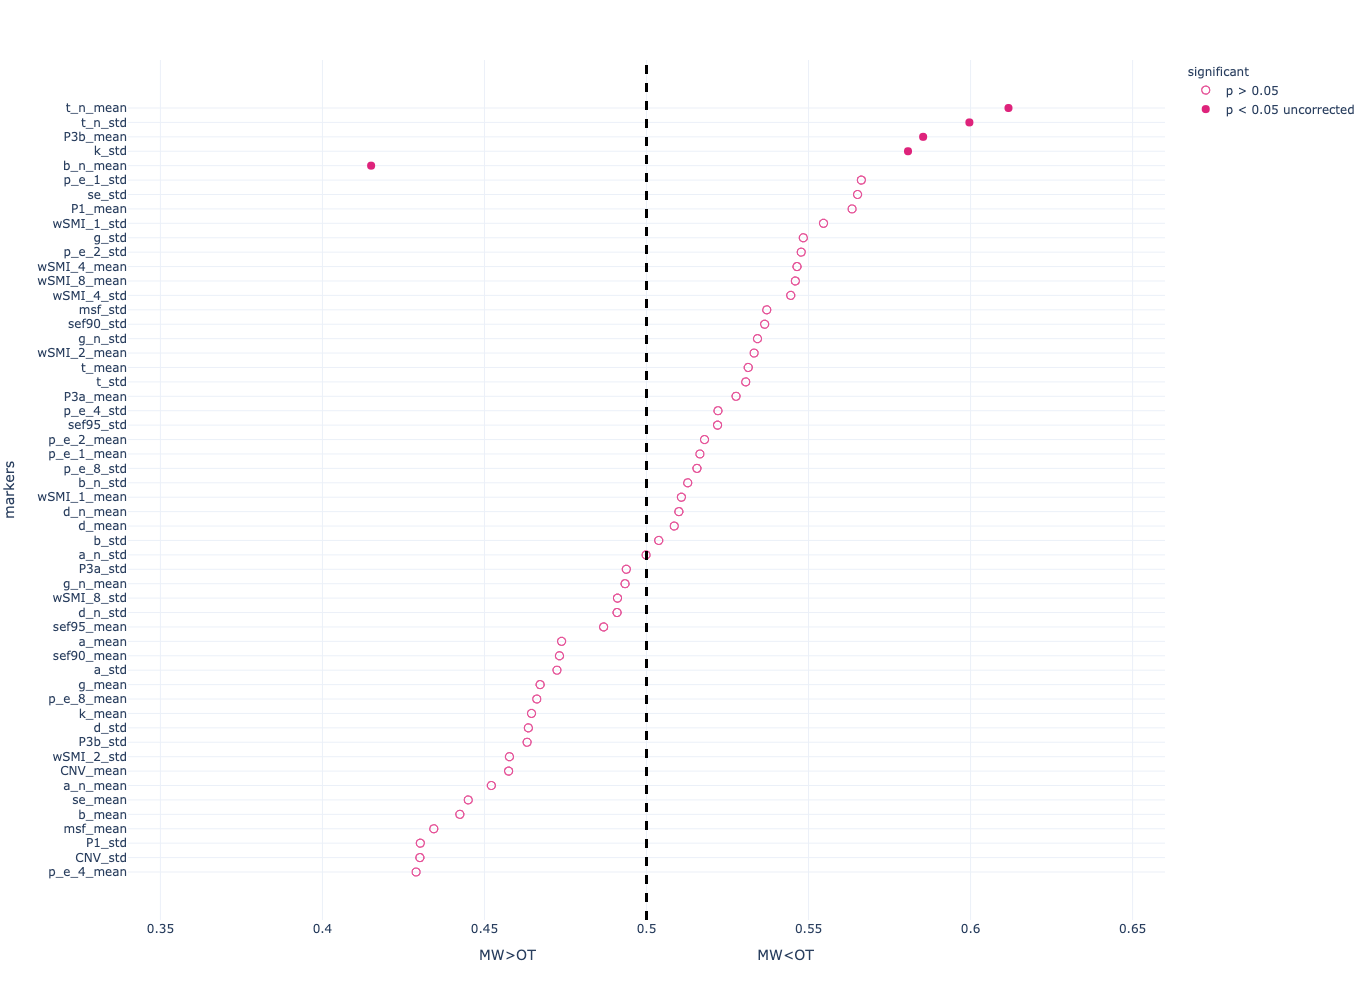

In [127]:
segment_mind_roc = pd.read_csv('Data/univariate_roc_mind_segment.csv')
fig = px.scatter(segment_mind_roc.sort_values(by = 'AUC'),x = 'AUC', y = 'markers', template = "plotly_white", symbol = 'significant', 
                 symbol_sequence = ['circle-open','circle','hexagram' ],
#                  color = 'significant',
                 color_discrete_sequence = [pink, green,orange, pink], 
                 
                 category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']},
                 labels = {'AUC': 'MW>OT                                             MW<OT'}
                )
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")
fig.update_traces(marker=dict(size = 8))

fig.update_layout(
    autosize=False,
    width=800,
    height=1000,
    xaxis= {'range': (0.34, 0.66)},
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
    
)
fig.show()
# pio.write_json(fig, 'Figs/univariate_roc_mw_segment.plotly')
# fig.write_image('Figs/univariate_roc_mw_segment.png')

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [128]:
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
)

# df_mw.columns = df_mw.columns.map("_".join)

# df_mw  = (df_mw
#             .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment'})
#             .drop(['participant', 'probe', 'segment'], axis = 1) 
#            )


#### Use latex command for nmaes###
####it slow downs the computer, just for final figures.

df_mw = correct_name_markers(df_mw)

df_mw.columns = df_mw.columns.map("$_{".join).map(lambda x: x + '}$').map(lambda x: x.replace('$$', ''))

df_mw  = (df_mw
            .rename(columns = {'participant$_{first}$':'participant', 'probe$_{first}$':'probe', 'mind$_{first}$':'mind', 'segment$_{first}$':'segment', 'mind$_{}$':'mind'})
#             .query("mind != 'dMW'") #if you want to test against just one of the mw   
            .drop(['participant', 'probe',  'segment'], axis = 1)

           )

In [138]:
AUC = []
pvalues = {}
for i in df_mw.drop('mind', axis = 1).columns:
    df_mw = df_mw.assign(mind_order = lambda df: np.select([df.mind == 'dMW', df.mind == 'sMW'], [2,1]))
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind_order'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = smw, y = dmw)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = smw, y =dmw).pvalue 
        
segment_mw_roc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
segment_mw_roc = (segment_mw_roc
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(
                    p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05']),
                   )
           )

segment_mw_roc.to_csv('Data/univariate_roc_mw_segment.csv')

AUC $wSMI\gamma_{mean}$ = 0.46493706293706294 MannwhitneyuResult(statistic=33243.0, pvalue=0.08056843744396058)
AUC $wSMI\gamma_{std}$ = 0.4743496503496504 MannwhitneyuResult(statistic=33916.0, pvalue=0.15267741318427164)
AUC $wSMI\beta_{mean}$ = 0.4983496503496503 MannwhitneyuResult(statistic=35632.0, pvalue=0.47381297550756285)
AUC $wSMI\beta_{std}$ = 0.4823356643356644 MannwhitneyuResult(statistic=34487.0, pvalue=0.24015616398303097)
AUC $wSMI\alpha_{mean}$ = 0.4939020979020979 MannwhitneyuResult(statistic=35314.0, pvalue=0.4038221457248214)
AUC $wSMI\alpha_{std}$ = 0.52 MannwhitneyuResult(statistic=34320.0, pvalue=0.21209835141963734)
AUC $wSMI\theta_{mean}$ = 0.5207132867132866 MannwhitneyuResult(statistic=34269.0, pvalue=0.20392781220127076)
AUC $wSMI\theta_{std}$ = 0.5153706293706294 MannwhitneyuResult(statistic=34651.0, pvalue=0.2695692875403644)
AUC $PE\gamma_{mean}$ = 0.44167832167832166 MannwhitneyuResult(statistic=31580.0, pvalue=0.009877788763454468)
AUC $PE\gamma_{std}$ =

In [139]:
df_agg = df_mw.melt(id_vars=['mind'], var_name = 'markers', value_name = 'value').groupby(['markers','mind'], as_index = False).agg(['mean','std'], axis = 0).reset_index()
df_agg.columns = df_agg.columns.map(''.join)

df_mw_final = (df_agg.merge(segment_mw_roc, on = 'markers', how= 'inner')
                 .drop(['significant'], axis =1)
#                  .assign(mind = lambda df: df.mind.str.replace('d', 'MW').replace('on-task','OT'))
                )

                                                                                 
print(df_mw_final.to_latex(header = True, index= False, float_format="{:0.3f}".format, escape = False, longtable=True))

\begin{longtable}{llrrrrr}
\toprule
            markers & mind &  valuemean &  valuestd &   AUC &  p_value &  p_corrected \\
\midrule
\endfirsthead

\toprule
            markers & mind &  valuemean &  valuestd &   AUC &  p_value &  p_corrected \\
\midrule
\endhead
\midrule
\multicolumn{7}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
       $CNV_{mean}$ &  dMW &     -0.761 &     6.928 & 0.496 &    0.444 &        0.471 \\
       $CNV_{mean}$ &  sMW &     -0.846 &     6.852 & 0.496 &    0.444 &        0.471 \\
        $CNV_{std}$ &  dMW &      8.571 &     5.256 & 0.496 &    0.442 &        0.471 \\
        $CNV_{std}$ &  sMW &      8.808 &     6.018 & 0.496 &    0.442 &        0.471 \\
         $K_{mean}$ &  dMW &      0.774 &     0.010 & 0.496 &    0.437 &        0.471 \\
         $K_{mean}$ &  sMW &      0.774 &     0.010 & 0.496 &    0.437 &        0.471 \\
          $K_{std}$ &  dMW &      0.005 &     0.003 & 0.483 &    0.243 &        0.375 \\
          $

In [35]:
AUC = pd.DataFrame()
pvalues = {}
for i in df_mw.drop('mind', axis = 1).columns:
    

    AUC[i], pvalues[i] =  univariate_classifier(
    data= df_mw, label = 'mind', feature = i, model = 'SVM', grid_search=False, permutation=True, n_permutations = 1000
)

    
p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
svc_mw = (AUC.reset_index().melt(id_vars = ['index'], var_name = 'markers', value_name = 'AUC')
            .drop('index', axis = 1)
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05']))
           )
svc_mw.to_csv('Data/univariate_svc_mw.csv')

AUC wSMI_1_mean = 0.5220591133004927
p_value = 0.22877122877122877
AUC wSMI_1_std = 0.5199113300492612
p_value = 0.24675324675324675
AUC wSMI_2_mean = 0.5065714285714286
p_value = 0.41058941058941056
AUC wSMI_2_std = 0.459807881773399
p_value = 0.9070929070929071
AUC wSMI_4_mean = 0.49175862068965515
p_value = 0.6133866133866134
AUC wSMI_4_std = 0.5197684729064039
p_value = 0.24275724275724275
AUC wSMI_8_mean = 0.48403940886699515
p_value = 0.7172827172827173
AUC wSMI_8_std = 0.49996551724137933
p_value = 0.4885114885114885
AUC p_e_1_mean = 0.5563645320197044
p_value = 0.016983016983016984
AUC p_e_1_std = 0.49500985221674887
p_value = 0.5444555444555444
AUC p_e_2_mean = 0.5656305418719212
p_value = 0.00999000999000999
AUC p_e_2_std = 0.48058128078817736
p_value = 0.7342657342657343
AUC p_e_4_mean = 0.49524137931034484
p_value = 0.5704295704295704
AUC p_e_4_std = 0.5191871921182266
p_value = 0.2647352647352647
AUC p_e_8_mean = 0.6303152709359605
p_value = 0.000999000999000999
AUC p_e_8_

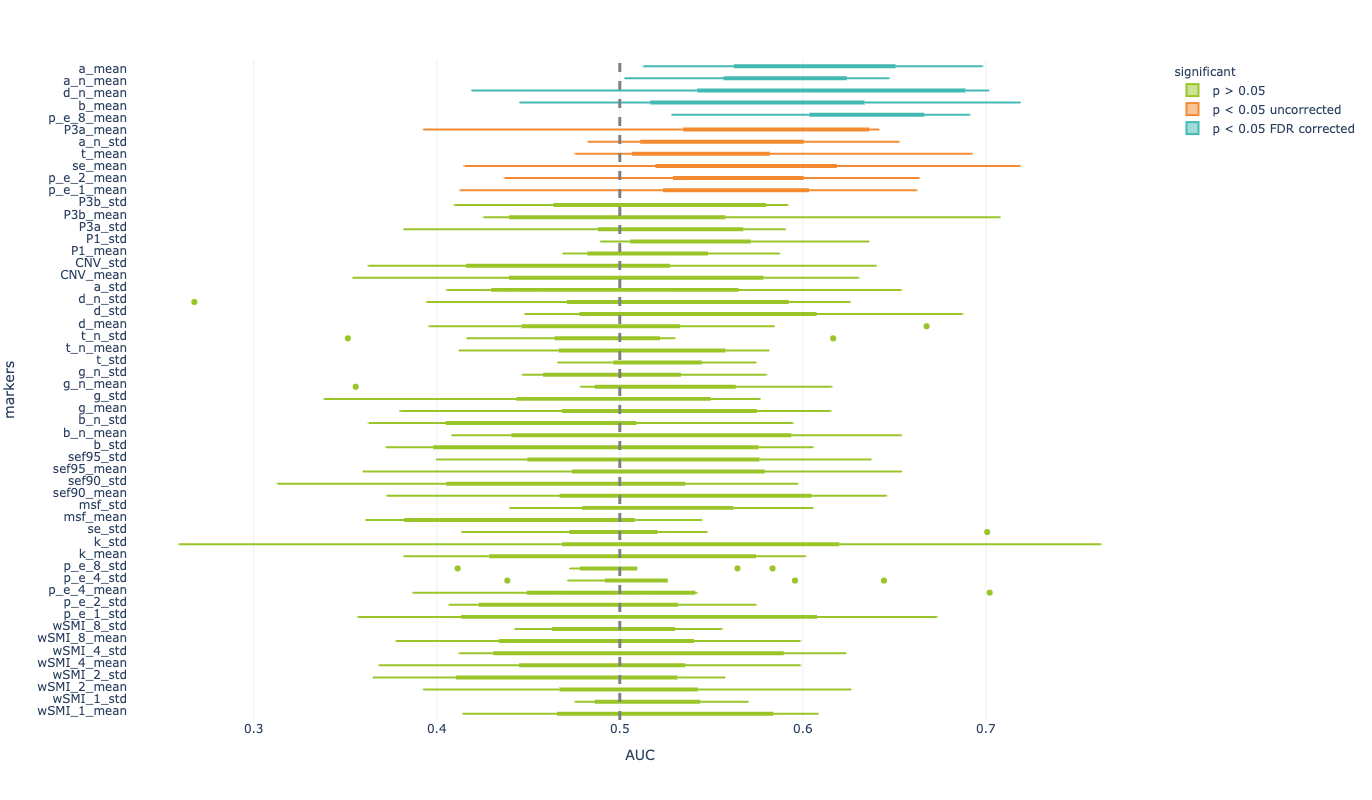

In [36]:
svc_mw = pd.read_csv('Data/univariate_svc_mw.csv')

fig = px.box(svc_mw, y="markers", x="AUC", color="significant", template = "plotly_white", color_discrete_sequence = [green, orange, lblue])
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
)


fig.show()
pio.write_json(fig, 'Figs/univariate_svc_mw_segment.plotly')


## Probe Caught vs Self-Caught


In [13]:
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_probe = (
    df_markers
    .query("mind != 'on-task'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
)

# df_probe.columns = df_probe.columns.map("_".join)

# df_probe  = (df_probe
#             .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment'})
#             .drop(['participant', 'mind', 'segment'], axis = 1) 
#            )

#### Use latex command for nmaes###
##it slow downs the computer, just for final figures.

df_probe = correct_name_markers(df_probe)

df_probe.columns = df_probe.columns.map("$_{".join).map(lambda x: x + '}$').map(lambda x: x.replace('$$', ''))

df_probe  = (df_probe
            .rename(columns = {'participant$_{first}$':'participant', 'probe$_{first}$':'probe', 'mind$_{first}$':'mind', 'segment$_{first}$':'segment'})
           
            .drop(['participant', 'mind', 'segment'], axis = 1) 
           )

In [23]:
sc = df_probe[df_probe.probe == 'SC']
pc = df_probe[df_probe.probe == 'PC']
print(f'SC {len(sc)}, PC: {len(pc)}')

AUC = []
pvalues = {}
for i in df_probe.drop('probe', axis = 1).columns:
    rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

    probe_rus = rus.fit_resample(df_probe[i].astype("float32").values.reshape(-1,1), df_probe.probe)

    df_probe_rus = pd.DataFrame(probe_rus[0], columns =['marker']).assign(probe = probe_rus[1])
    
    sc = df_probe_rus.query("probe == 'SC'")['marker']
    pc = df_probe_rus.query("probe == 'PC'")['marker']
    auc = roc_auc_score(df_probe_rus['probe'], df_probe_rus['marker'])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = sc, y = pc)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = sc, y =pc).pvalue 
        
probe_roc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
probe_roc_rus = (probe_roc
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(
                    p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05']),
                                    balance = 'under-sample'
                   )
           )

probe_roc.to_csv('Data/univariate_roc_probe.csv')

SC 536, PC: 82
AUC $wSMI\gamma_{mean}$ = 0.4805175490779299 MannwhitneyuResult(statistic=3231.0, pvalue=0.3338934893050117)
AUC $wSMI\gamma_{std}$ = 0.46519928613920286 MannwhitneyuResult(statistic=3128.0, pvalue=0.22126358486974412)
AUC $wSMI\beta_{mean}$ = 0.5001487209994051 MannwhitneyuResult(statistic=3361.0, pvalue=0.49934398140473885)
AUC $wSMI\beta_{std}$ = 0.5028256989886972 MannwhitneyuResult(statistic=3343.0, pvalue=0.47574226827599847)
AUC $wSMI\alpha_{mean}$ = 0.5355443188578228 MannwhitneyuResult(statistic=3123.0, pvalue=0.21640956656015292)
AUC $wSMI\alpha_{std}$ = 0.5093694229625223 MannwhitneyuResult(statistic=3299.0, pvalue=0.4185714384878534)
AUC $wSMI\theta_{mean}$ = 0.5553242117787031 MannwhitneyuResult(statistic=2990.0, pvalue=0.11089430913683834)
AUC $wSMI\theta_{std}$ = 0.48393813206424746 MannwhitneyuResult(statistic=3254.0, pvalue=0.3618399372440914)
AUC $PE\gamma_{mean}$ = 0.4867638310529447 MannwhitneyuResult(statistic=3273.0, pvalue=0.38550347915724836)
AUC 

In [24]:
AUC = []
pvalues = {}
for i in df_probe.drop('probe', axis = 1).columns:
    ros = SMOTE(random_state=42)# fit predictor and target variable

    probe_ros = ros.fit_resample(df_probe[i].astype("float32").values.reshape(-1,1), df_probe.probe)

    df_probe_ros = pd.DataFrame(probe_ros[0], columns =['marker']).assign(probe = probe_ros[1])
    
    sc = df_probe_ros.query("probe == 'SC'")['marker']
    pc = df_probe_ros.query("probe == 'PC'")['marker']
    auc = roc_auc_score(df_probe_ros['probe'], df_probe_ros['marker'])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = sc, y = pc)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = sc, y =pc).pvalue 
        
probe_roc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
probe_roc_ros = (probe_roc
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(
                    p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05']),
                    balance = 'over-sample'
                   )
           )

probe_roc.to_csv('Data/univariate_roc_probe.csv')

AUC $wSMI\gamma_{mean}$ = 0.427800943974159 MannwhitneyuResult(statistic=122905.5, pvalue=2.1347846646664334e-05)
AUC $wSMI\gamma_{std}$ = 0.43507393071953665 MannwhitneyuResult(statistic=124995.0, pvalue=0.00011655807973401565)
AUC $wSMI\beta_{mean}$ = 0.4799022610826465 MannwhitneyuResult(statistic=137874.0, pvalue=0.1273289234452048)
AUC $wSMI\beta_{std}$ = 0.4637133827132992 MannwhitneyuResult(statistic=133223.0, pvalue=0.019855208301989332)
AUC $wSMI\alpha_{mean}$ = 0.48971444085542437 MannwhitneyuResult(statistic=140693.0, pvalue=0.2799731216021557)
AUC $wSMI\alpha_{std}$ = 0.4942881209623524 MannwhitneyuResult(statistic=142007.0, pvalue=0.37309401079240734)
AUC $wSMI\theta_{mean}$ = 0.5124871212965025 MannwhitneyuResult(statistic=140060.5, pvalue=0.23956166187453143)
AUC $wSMI\theta_{std}$ = 0.48989543885052345 MannwhitneyuResult(statistic=140745.0, pvalue=0.28343685937248086)
AUC $PE\gamma_{mean}$ = 0.4506954499888617 MannwhitneyuResult(statistic=129483.0, pvalue=0.002597807048

In [56]:
probe_roc = pd.concat([probe_roc_ros, probe_roc_rus])

df_agg = df_probe.melt(id_vars=['probe'], var_name = 'markers', value_name = 'value').groupby(['markers','probe'], as_index = False).agg(['mean','std'], axis = 0).reset_index()
df_agg.columns = df_agg.columns.map(''.join)

df_probe_final = (df_agg.merge(probe_roc, on = 'markers', how= 'inner')
                 .drop(['significant'], axis =1)
#                  .assign(mind = lambda df: df.mind.str.replace('d', 'MW').replace('on-task','OT'))
                )

                                                                                 
print(df_probe_final.to_latex(header = True, index= False, float_format="{:0.3f}".format, escape = False, longtable=True))

\begin{longtable}{llrrrrrl}
\toprule
            markers & probe &  valuemean &  valuestd &   AUC &  p_value &  p_corrected &      balance \\
\midrule
\endfirsthead

\toprule
            markers & probe &  valuemean &  valuestd &   AUC &  p_value &  p_corrected &      balance \\
\midrule
\endhead
\midrule
\multicolumn{8}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
       $CNV_{mean}$ &    PC &      2.938 &     9.159 & 0.394 &    0.000 &        0.000 &  over-sample \\
       $CNV_{mean}$ &    PC &      2.938 &     9.159 & 0.353 &    0.001 &        0.031 & under-sample \\
       $CNV_{mean}$ &    SC &     -0.801 &     6.886 & 0.394 &    0.000 &        0.000 &  over-sample \\
       $CNV_{mean}$ &    SC &     -0.801 &     6.886 & 0.353 &    0.001 &        0.031 & under-sample \\
        $CNV_{std}$ &    PC &      9.160 &     5.906 & 0.480 &    0.123 &        0.215 &  over-sample \\
        $CNV_{std}$ &    PC &      9.160 &     5.906 & 0.491 &    0.419 &   

# By Trial Univariate analyses

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [231]:
agg_dict = {k:'mean' for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers
    .query("probe == 'PC'")
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
    .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) # drop mind or mind2 also
)

In [232]:
AUC = []
pvalues = {}
for i in df_mind.drop('mind2', axis = 1).columns:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = ot, y = mw)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = ot, y = mw).pvalue 
        
trial_mind_roc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
trial_mind_roc = (trial_mind_roc
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(
                    p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05'])
                   )
           )
trial_mind_roc.to_csv('Data/univariate_roc_mind_trial.csv')

AUC wSMI_1 = 0.4927448450214626 MannwhitneyuResult(statistic=37422.0, pvalue=0.3843806894864651)
AUC wSMI_2 = 0.5181444710715509 MannwhitneyuResult(statistic=36595.0, pvalue=0.23096997767776806)
AUC wSMI_4 = 0.5206857504016011 MannwhitneyuResult(statistic=36402.0, pvalue=0.20081093379294496)
AUC wSMI_8 = 0.5112448318542122 MannwhitneyuResult(statistic=37119.0, pvalue=0.32426218739075374)
AUC p_e_1 = 0.5182103073236246 MannwhitneyuResult(statistic=36590.0, pvalue=0.23015804797957068)
AUC p_e_2 = 0.5225423327100835 MannwhitneyuResult(statistic=36261.0, pvalue=0.18035068409966132)
AUC p_e_4 = 0.4397729966028494 MannwhitneyuResult(statistic=33399.0, pvalue=0.007293260345101261)
AUC p_e_8 = 0.4814473441655913 MannwhitneyuResult(statistic=36564.0, pvalue=0.22596185055481743)
AUC k = 0.47977510336291573 MannwhitneyuResult(statistic=36437.0, pvalue=0.2060964294458162)
AUC msf = 0.45930002896795097 MannwhitneyuResult(statistic=34882.0, pvalue=0.04942165309067732)
AUC sef90 = 0.48181602717720484

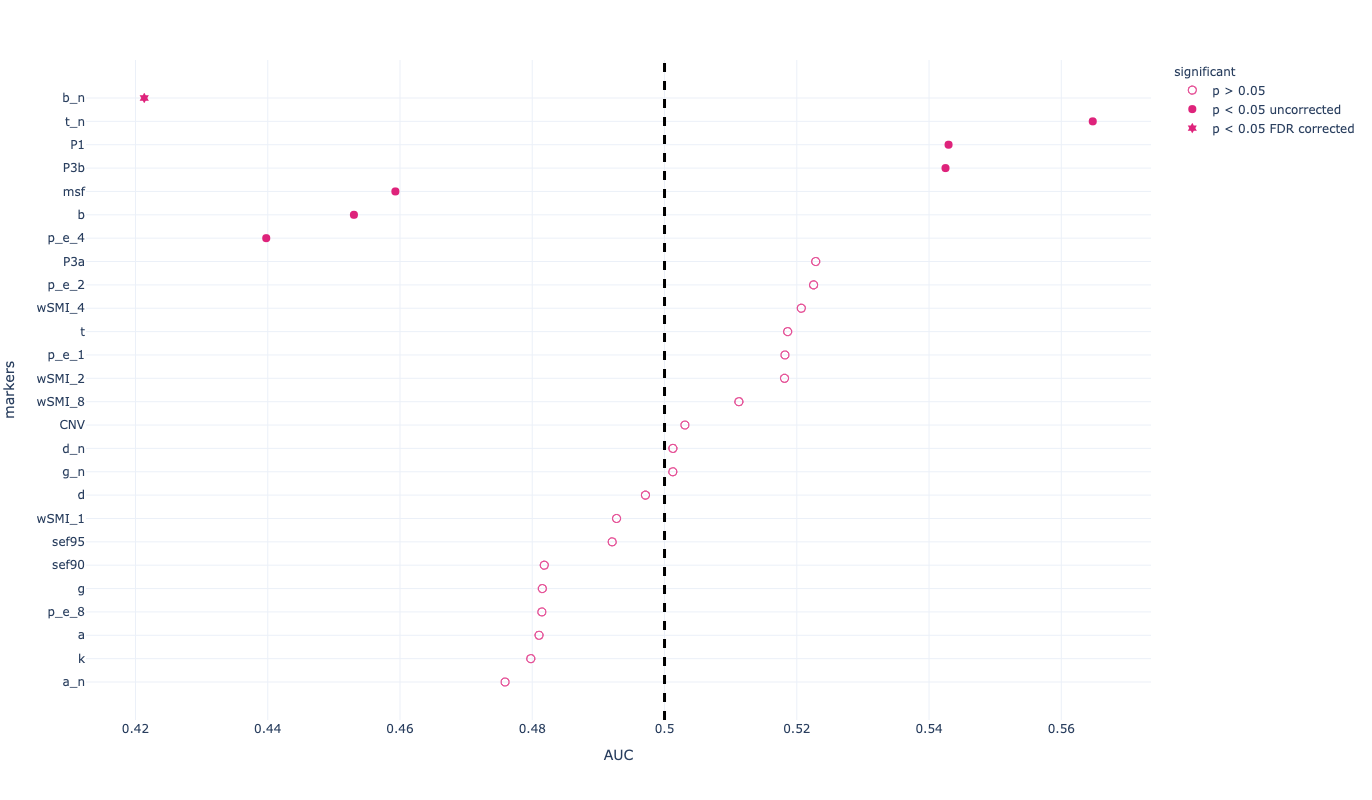

In [234]:
trial_mind_roc = pd.read_csv('Data/univariate_roc_mind_trial.csv')
fig = px.scatter(trial_mind_roc.sort_values(by = 'AUC'),x = 'AUC', y = 'markers', template = "plotly_white", symbol = 'significant', 
                 symbol_sequence = ['circle-open','circle','hexagram' ],
#                  color = 'significant',
                 color_discrete_sequence = [pink, green,orange, pink], 
                 
                 category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']})
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")
fig.update_traces(marker=dict(size = 8))

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
    
)
fig.show()
pio.write_json(fig, 'Figs/univariate_roc_mw_segment.plotly')
# fig.write_image('Figs/univariate_roc_mw_segment.png')

In [48]:
AUC = pd.DataFrame()
pvalues = {}
for i in df_mind.drop('mind2', axis = 1).columns:
    

    AUC[i], pvalues[i] =  univariate_classifier(
    data= df_mind, label = 'mind2', feature = i, model = 'SVM', grid_search=False, permutation=True, n_permutations = 1000
)

    
p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
svc_mind_trial = (AUC.reset_index().melt(id_vars = ['index'], var_name = 'markers', value_name = 'AUC')
            .drop('index', axis = 1)
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(significant = lambda df: np.where(df.p_value< 0.05, 'Signficant', 'Not significant'))
           )
svc_mind_trial.to_csv('Data/univariate_svc_mind_trial.csv')

AUC wSMI_1 = 0.4904762157382847
p_value = 0.6313686313686314
AUC wSMI_2 = 0.5092984969053934
p_value = 0.3516483516483517
AUC wSMI_4 = 0.4992732095490716
p_value = 0.5194805194805194
AUC wSMI_8 = 0.4958969053934571
p_value = 0.5694305694305695
AUC p_e_1 = 0.5071076923076923
p_value = 0.35764235764235763
AUC p_e_2 = 0.5026443854995579
p_value = 0.46853146853146854
AUC p_e_4 = 0.540705216622458
p_value = 0.07892107892107893
AUC p_e_8 = 0.4901211317418214
p_value = 0.6093906093906094
AUC k = 0.5052061892130858
p_value = 0.4275724275724276
AUC b = 0.55764350132626
p_value = 0.016983016983016984
AUC b_n = 0.5590843501326261
p_value = 0.013986013986013986
AUC g = 0.4571798408488063
p_value = 0.945054945054945
AUC g_n = 0.46338638373121127
p_value = 0.8831168831168831
AUC t = 0.4609236074270557
p_value = 0.936063936063936
AUC t_n = 0.48273492484526975
p_value = 0.6973026973026973
AUC d = 0.5066611847922193
p_value = 0.3866133866133866
AUC d_n = 0.5275541998231653
p_value = 0.17882117882117882

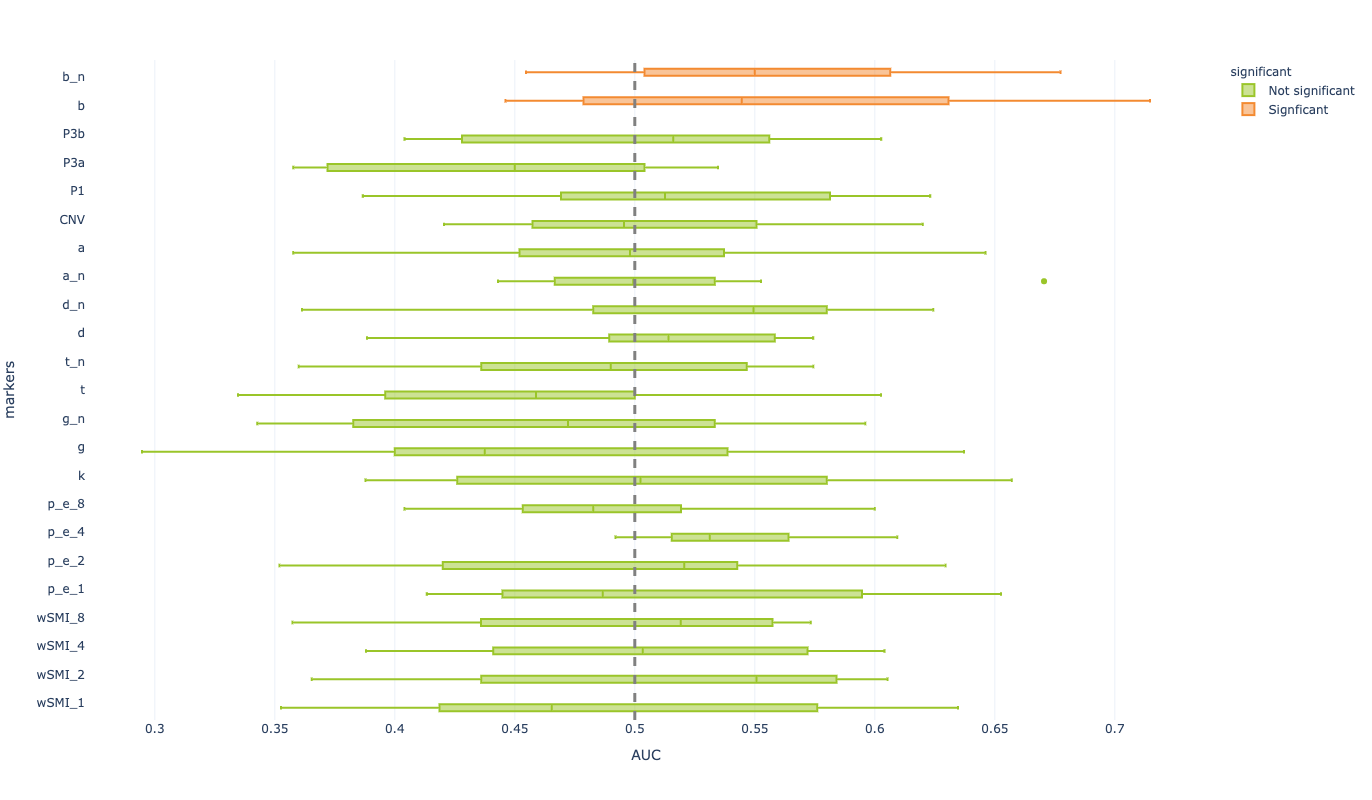

In [49]:
svc_mind_trial = pd.read_csv('Data/univariate_svc_mind_trial.csv')

fig = px.box(svc_mind_trial, y="markers", x="AUC", color="significant", template = "plotly_white", color_discrete_sequence = [green, orange])
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
)
fig.show()
pio.write_json(fig, 'Figs/univariate_svc_mind_trial.plotly')

In [ ]:
n_estimators = 2000
AUC = pd.DataFrame()
for i in  df_mind.drop('mind2', axis = 1).columns:
    
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    
    doc_forest = make_pipeline(
        RobustScaler(),
        ExtraTreesClassifier(
            n_estimators=n_estimators, max_features=1, criterion='entropy',
            max_depth=4, random_state=42, class_weight='balanced'))

    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
                           random_state=42)

    aucs = cross_val_score(
        X=X, y=y, estimator=doc_forest,
        scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')

sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [42]:
df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .drop(['participant', 'probe', 'segment'], axis = 1)
)

In [43]:
AUC = []
pvalues = {}
for i in df_mw.drop('mind', axis = 1).columns:
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = smw, y = dmw)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = smw, y =dmw).pvalue 
        
trial_mw_roc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
trial_mw_roc = (trial_mw_roc
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(
                    p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05']),
                   )
           )

trial_mw_roc.to_csv('Data/univariate_roc_mw_trial.csv')

AUC wSMI_1 = 0.45596723142803947 MannwhitneyuResult(statistic=7347.0, pvalue=0.11282245710803301)
AUC wSMI_2 = 0.5152361447278595 MannwhitneyuResult(statistic=7811.0, pvalue=0.33771930001685746)
AUC wSMI_4 = 0.5155464531744554 MannwhitneyuResult(statistic=7806.0, pvalue=0.33460211018768227)
AUC wSMI_8 = 0.5369577359895736 MannwhitneyuResult(statistic=7461.0, pvalue=0.15461662815128185)
AUC p_e_1 = 0.5159808849996896 MannwhitneyuResult(statistic=7799.0, pvalue=0.330257169081169)
AUC p_e_2 = 0.5013963880096816 MannwhitneyuResult(statistic=8034.0, pvalue=0.48500443721025216)
AUC p_e_4 = 0.4677589523986843 MannwhitneyuResult(statistic=7537.0, pvalue=0.18755260837356108)
AUC p_e_8 = 0.5880965679885806 MannwhitneyuResult(statistic=6637.0, pvalue=0.007653842347483183)
AUC k = 0.5220939613976292 MannwhitneyuResult(statistic=7700.5, pvalue=0.27174552824418685)
AUC msf = 0.579563085707193 MannwhitneyuResult(statistic=6774.5, pvalue=0.014260797776196519)
AUC sef90 = 0.5494321355427295 Mannwhitney

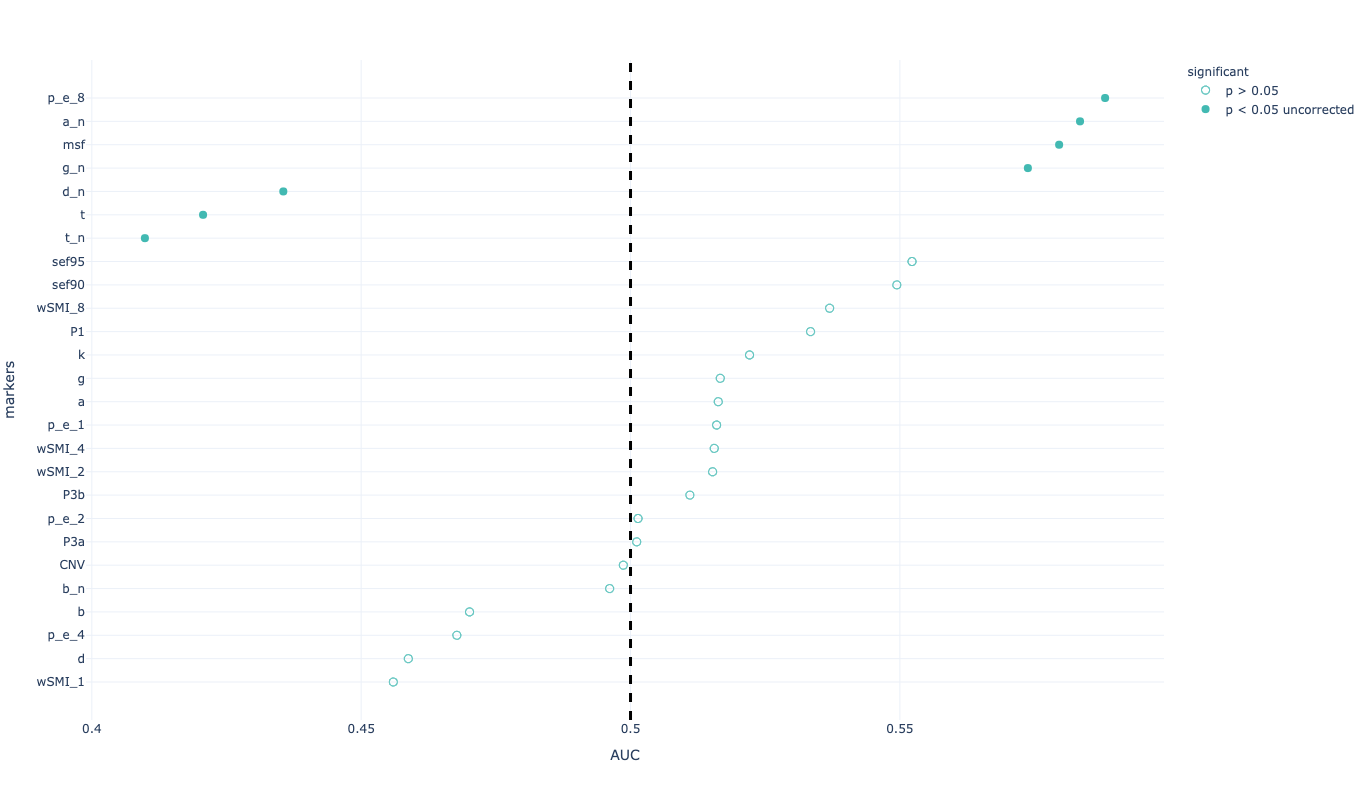

In [44]:
trial_mw_roc = pd.read_csv('Data/univariate_roc_mw_trial.csv')
fig = px.scatter(trial_mw_roc.sort_values(by = 'AUC'),x = 'AUC', y = 'markers', template = "plotly_white", symbol = 'significant', 
                 symbol_sequence = ['circle-open','circle','hexagram' ],
#                  color = 'significant',
                 color_discrete_sequence = [lblue, green,orange, pink], 
                 
                 category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']})
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")

fig.update_traces(marker=dict(size = 8))
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
    
)
fig.show()
pio.write_json(fig, 'Figs/univariate_roc_mw_segment.plotly')
# fig.write_image('Figs/univariate_roc_mw_segment.png')

In [53]:
AUC = pd.DataFrame()
pvalues = {}
for i in df_mw.drop('mind', axis = 1).columns:
    

    AUC[i], pvalues[i] =  univariate_classifier(
    data= df_mw, label = 'mind', feature = i, model = 'SVM', grid_search=False, permutation=True, n_permutations = 1000
)

    
p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
svc_mw_trial = (AUC.reset_index().melt(id_vars = ['index'], var_name = 'markers', value_name = 'AUC')
            .drop('index', axis = 1)
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(significant = lambda df: np.where(df.p_value< 0.05, 'Signficant', 'Not significant'))
           )
svc_mw_trial.to_csv('Data/univariate_svc_mw_trial.csv')

AUC wSMI_1 = 0.5018059811855137
p_value = 0.46853146853146854
AUC wSMI_2 = 0.4859879601599989
p_value = 0.8411588411588412
AUC wSMI_4 = 0.497206063839827
p_value = 0.5744255744255744
AUC wSMI_8 = 0.48274134385335027
p_value = 0.8731268731268731
AUC p_e_1 = 0.5641385413847138
p_value = 0.000999000999000999
AUC p_e_2 = 0.5727134804310468
p_value = 0.000999000999000999


KeyboardInterrupt: 

In [ ]:
pd.read_csv('Data/univariate_svc_mw_trial.csv')

fig = px.box(svc_mw_trial, y="markers", x="AUC", color="significant", template = "plotly_white", color_discrete_sequence = [green, orange])
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
)


fig.show()
pio.write_json(fig, 'Figs/univariate_svc_mw_trial.plotly')


# Plots

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

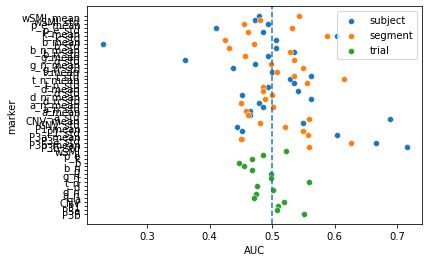

In [135]:
sns.scatterplot(x = 'AUC', y = 'marker', data = subject_mind_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = segment_mind_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = trial_mind_roc)
plt.legend(['subject','segment', 'trial'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

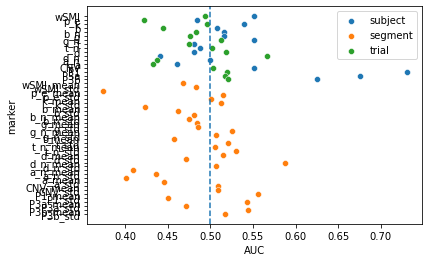

In [136]:
sns.scatterplot(x = 'AUC', y = 'marker', data = subject_mw_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = segment_mw_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = trial_mw_roc)
plt.legend(['subject','segment', 'trial'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## Comparison of significan markers for Mind and Mw

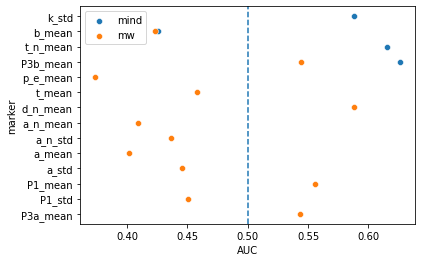

In [134]:
sns.scatterplot(x = 'AUC', y = 'marker', data = significants_mind )
sns.scatterplot(x = 'AUC', y = 'marker', data = significants_mw )
plt.legend(['mind','mw'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()